In [512]:
from model import *

import time
import sys
#!{sys.executable} -m pip install [arg]

import random

import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import networkx as nx

import numpy as np
from itertools import permutations
from sklearn.metrics import euclidean_distances


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")


In [2]:
gamma  = 2.1 # utility function parameter
A      = 1.2 # utility function parameter
r0     = 0.5 # left bound for uniform random return on project
r1     = 2.5 # right bound for uniform random return on project
r_hat  = 1.1 # safe return
I      = 0.3 # amount needed to undertake project
e_bar  = 1.5 # amount of entrepreneurial effort needed to undertake project
r_bar  = (1/(r1-r0)) * integrate.quad(lambda x: x, r0, r1)[0] # expected project return
w_init = 0.1

# Example

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

In [4]:
data = Data(x=x, edge_index=edge_index)

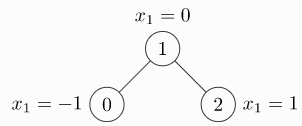

# Model

`propagate()` internally calls `message()`, `aggregate()` and `update()`

In [5]:
class Graph(MessagePassing):
    
    
    def __init__(self, N, w_init):
        """
        N      : number of agent nodes
        w_init : initial wealth of agents
        """
        # construct edges
        pairs = list(permutations(range(N), 2))    
        edge_index = torch.tensor(pairs, dtype=torch.long).t().contiguous()

        # initial wealth levels
        x = torch.tensor([[w_init]*N], dtype=torch.float).t()

        # construct Data object
        # weights all equal since wealth distribution is uniform initially
        self.data = Data(x=x, edge_index=edge_index, edge_weights=torch.ones(edge_index.shape))
        
        
    def forward(self):
        pass
    

    def message(self):
        pass

In [353]:
def connection_probability(D, alpha=1, b=0.1):
    return 1 / (1+((1/b)*D)**alpha)

In [354]:
def wealth_map(x, k=2):
    return 2*np.arctan(k*x)/np.pi

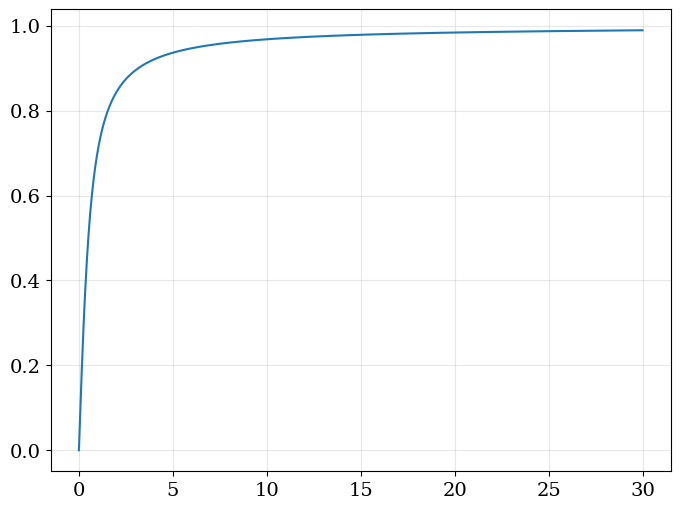

In [355]:
xvals = np.linspace(0,30,1000)2
plt.plot(xvals, wealth_map(xvals))
plt.show()

In [385]:
def prob_join_group(w):
    return 1 - wealth_map(w, k=3)

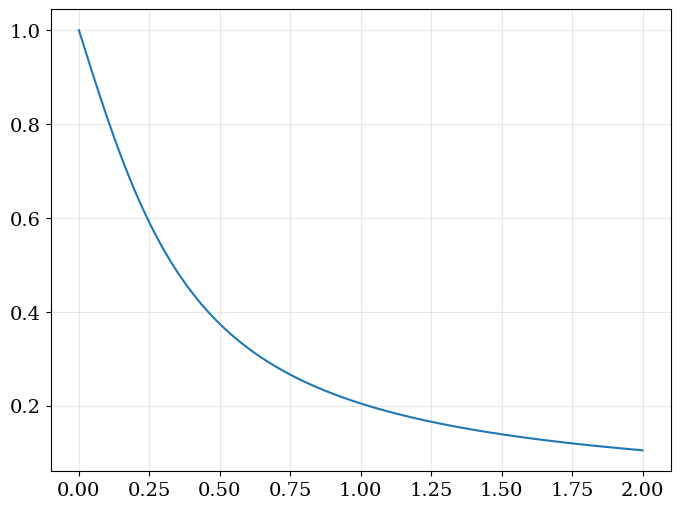

In [386]:
xvals = np.linspace(0,2,1000)
plt.plot(xvals, prob_join_group(xvals))
plt.show()

In [387]:
r0 = 0.95
r1 = 1.25

print(f"Expected project return = {(r0+r1)/2}")

Expected project return = 1.1


In [388]:
num_agents = 1000
agents = list(range(num_agents))

project_cost = 10

wealth_depreciation = 0.97

WEALTH = np.random.uniform(0.3, 0.7, num_agents).reshape(-1,1)

REPS = 100

wealths = [WEALTH]

for period in range(REPS):    
    
    random.shuffle(agents)
    WEALTH = np.copy(WEALTH)

    # compute homophily-based adjacency matrix
    D   = euclidean_distances(wealth_map(WEALTH))
    P   = connection_probability(D)
    ADJ = P > np.random.uniform(size=(num_agents,num_agents))
    ADJ = np.tril(ADJ) + np.triu(ADJ.T, 1)
    np.fill_diagonal(ADJ, True)
    
    # agents decide if they want to undertake a project or not
    project_unwilling = prob_join_group(wealth_map(WEALTH)) < np.random.uniform(size=(num_agents,1))
    unavailable = set(np.where(project_unwilling)[0])
    
    for i in agents:
        
        if i not in unavailable:
            neighbors = np.where(ADJ[i])[0]
            neighbors = np.array([x for x in neighbors if x not in unavailable])        
            pooled_wealth = sum(WEALTH[j] for j in neighbors)

            # project is undertaken
            if pooled_wealth >= project_cost:
                unavailable  = unavailable.union(set(neighbors))
                outcome      = pooled_wealth * np.random.uniform(r0,r1)
                contribution = WEALTH[neighbors] / pooled_wealth
                # assign new wealth
                WEALTH[neighbors] = contribution*outcome
#             else:
#                  WEALTH[i] = WEALTH[i]*wealth_depreciation
#         else:   
#             WEALTH[i] = WEALTH[i]*wealth_depreciation
    
    wealths.append(WEALTH)

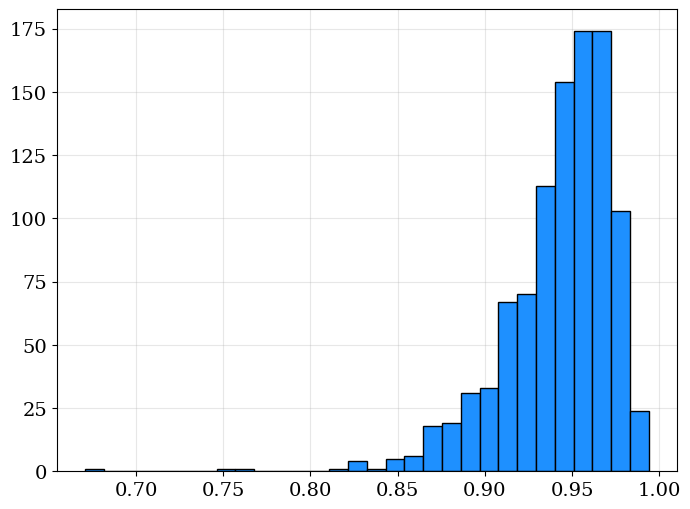

In [389]:
plt.hist(wealth_map(wealths[-1]), color="dodgerblue", edgecolor="k", bins=30)
plt.show()

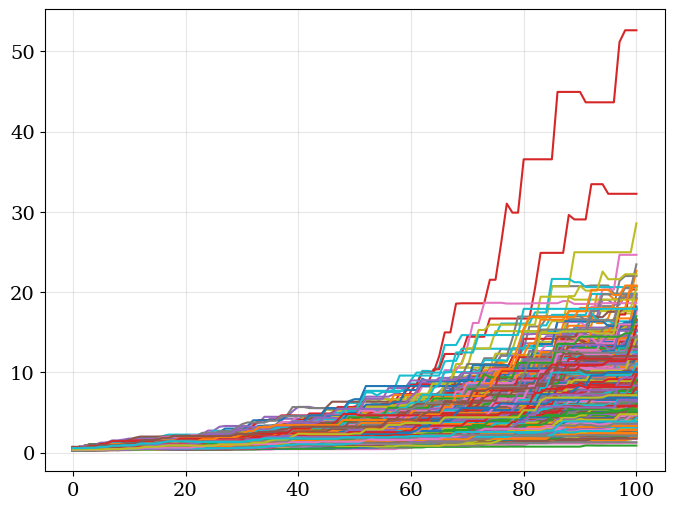

In [390]:
for a in range(num_agents):
    plt.plot([wealths[i][a] for i in range(len(wealths))])
plt.show()

# 1) Construct network

In [766]:
G = nx.powerlaw_cluster_graph(n=5000, m=3, p=0.5)
assert nx.is_connected(G)

adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())

# nx.draw(G, with_labels=True, font_weight='bold')

Mean degree = 5.995


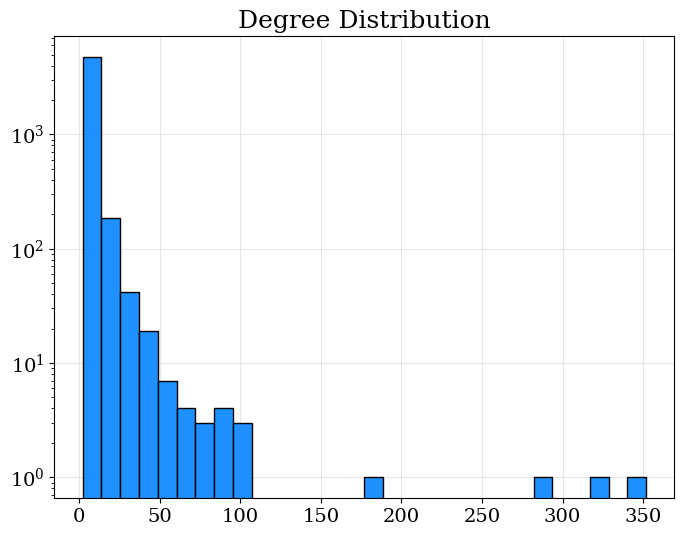

In [767]:
degrees = np.array(nx.degree(G))[:,1]
print(f"Mean degree = {np.mean(degrees):.3f}")
plt.hist(degrees, color="dodgerblue", edgecolor="k", bins=30)
plt.yscale("log")
plt.title("Degree Distribution")
plt.show()

# 2) Define groups

In [768]:
communities = list(nx.community.label_propagation_communities(G))
print(f"Number of communities : {len(communities)}")

Number of communities : 608


In [769]:
node_community_mapping = {}
for i,c in enumerate(communities):
    for node in c:
        node_community_mapping[node] = i

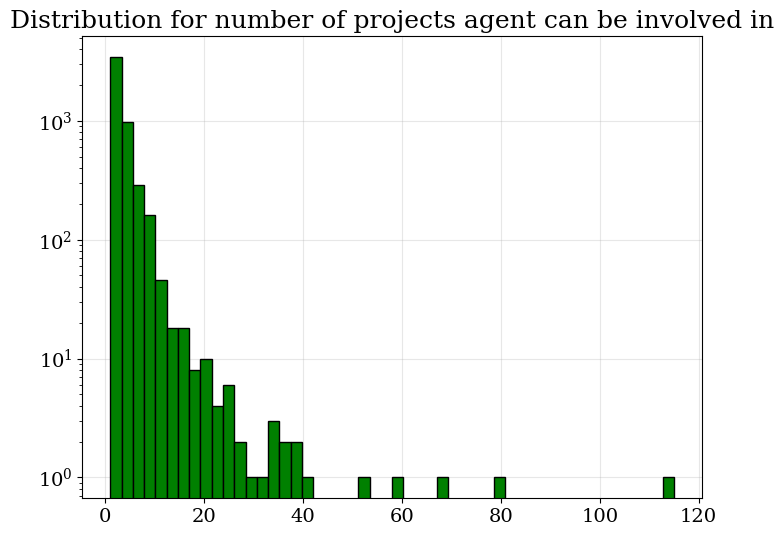

In [770]:
num_projects = []
for node in node_community_mapping:
    comms = {node_community_mapping[node]}
    for adj in adjacency[node]:
        comms.add(node_community_mapping[adj])
    num_projects.append(len(comms))
    
plt.hist(num_projects, color="green", edgecolor="k", bins=50)
plt.yscale("log")
plt.title("Distribution for number of projects agent can be involved in")
plt.show()

# 3) Generate gambles

In [771]:
def generate_gambles(N):
    """
    Generate N gambles with 2 outcomes.
    """
    probs1   = np.random.uniform(0.1, 0.9, N)
    probs2   = 1 - probs1
    outcomes = np.random.randint(1, 21, size=((N,2)))
    
    gambles = {}
    for i in range(N):
        gambles[i] = {
            "outcomes" : outcomes[i],
            "probs"    : [probs1[i],probs2[i]]
        }
                
    return gambles

# 4) Maximize expected utility

In [1032]:
def utility(x, w, project_expected_returns):
    
    consumption     = x[0]
    consumption_utility = U(consumption)
        
    savings = w - consumption
    project_weights = x[1:]
    project_utility = V(sum(savings * project_weights * project_expected_returns))
    
    return -(consumption_utility + project_utility)

In [1036]:
w = 3

bounds = ((w*0.1,w), (0.05,1.0), (0.05, 1.0))
cons = ({ 'type': 'eq', 'fun': lambda x:  1 - sum(x[1:]) })

rets = np.array([3, 8])

x0 = np.array([0.5, 0.4, 0.4])

result = minimize(utility, x0=x0, bounds=bounds, constraints=[cons], args=(w, rets, ), method='SLSQP')
print(result)

     fun: 0.5777964255862321
     jac: array([-6.97895885e-05, -5.87373599e-02, -1.56632952e-01])
 message: 'Optimization terminated successfully'
    nfev: 41
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([2.28359681, 0.05      , 0.95      ])


In [1037]:
optimal_consumption = []
for w in np.linspace(1, 50, 100):
    result = minimize(utility, x0=x0, bounds=bounds, constraints=[cons], args=(w, rets), method='SLSQP')
    optimal_consumption.append(result.x[0]/w)

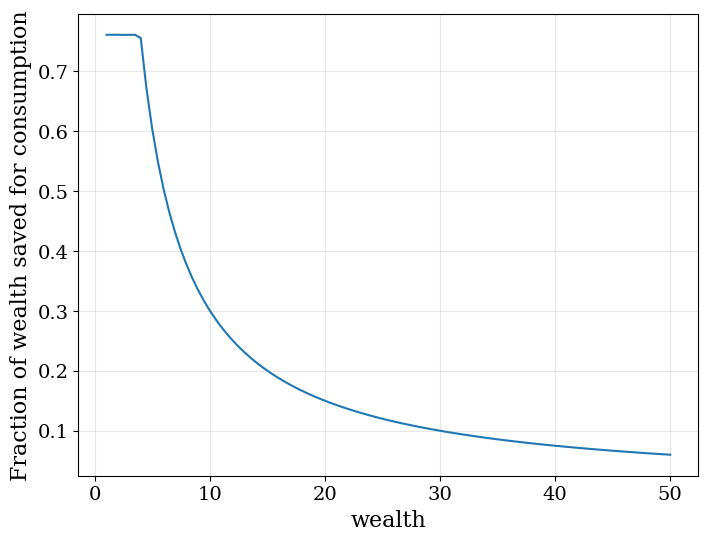

In [1038]:
plt.plot(np.linspace(1, 50, 100), optimal_consumption)
plt.xlabel("wealth")
plt.ylabel("Fraction of wealth saved for consumption")
plt.show()